# Transformation tendencies due to surface salt/heat flux

In [70]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [71]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.67bbfdc22f694f79848b95e388977d54/status,


In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
from xhistogram.xarray import histogram

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds  = cat["CESM_POP_hires_control"].to_dask()

In [3]:
ds

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_w: 62,
                         z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/59)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    vonkar              float64 ...
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    HMXL_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SFWF_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SHF_2               (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSH_2               (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUX_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUY_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U1_1                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U2_2                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    V1_1                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    V2_2                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    calendar:      All years have exactly  365 days.
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    contents:      Diagnostic and Prognostic Variables
    history:       none
    nsteps_total:  13088337
    revision:      $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy@ucar.edu $
    source:        CCSM POP2, the CCSM Ocean Component
    start_time:    This dataset was created on 2013-03-09 at 12:25:55.7
    tavg_sum:      86399.99999999962
    title:         hybrid_v5_rel04_BC5_ne120_t12_pop62

In [14]:
#Load in tendencies

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [15]:
drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/drhodts_tendencies_40yr.zarr'))

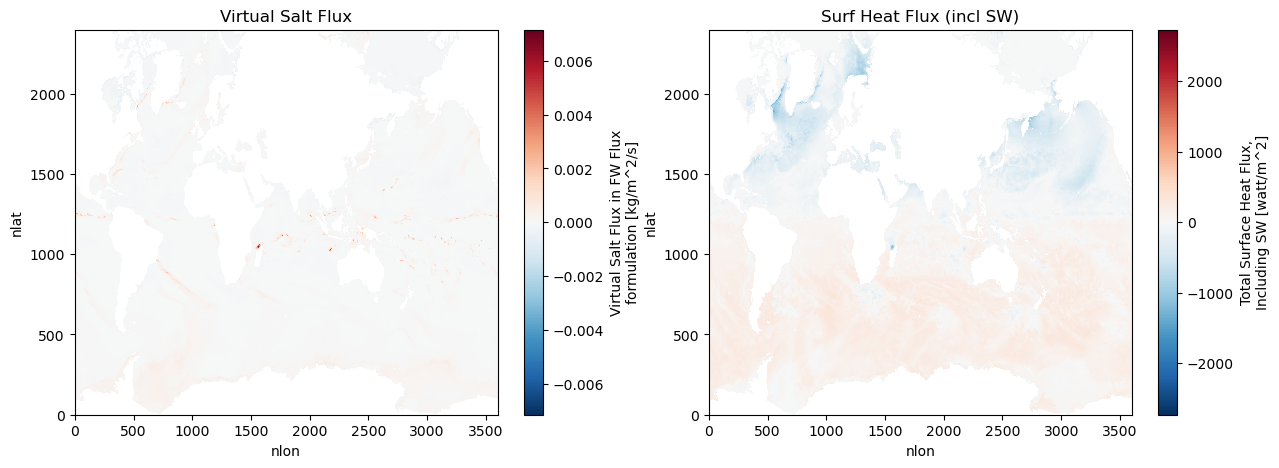

In [16]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))

ds.SFWF_2[0].plot(ax=ax0)
ax0.set_title('Virtual Salt Flux')

ds.SHF_2[0].plot(ax=ax1)
ax1.set_title('Surf Heat Flux (incl SW)');

In [17]:
rho0 = fastjmd95.rho(ds.SSS, ds.SST, 0)

In [21]:
rho0.mean().values

array(1025.04684843)

In [30]:
rho_const = 1025 #kg/m^3
heat_capacity = 3.994e3 #J/kg˚C
cm2_to_m2 = 1e-4

#surf salt flux
slt_flux = (ds.SFWF_2 * ds.SSS * ds.TAREA * cm2_to_m2) / rho_const #psu m^3 / s

#surf heat flux
heat_flux = (ds.SHF_2 * ds.TAREA * cm2_to_m2) / (rho_const * heat_capacity) #˚C m^3 / s

In [31]:
tend_surf_salt = drhodts.drhods * slt_flux
tend_surf_heat = drhodts.drhodt * heat_flux
#Units: kg/s

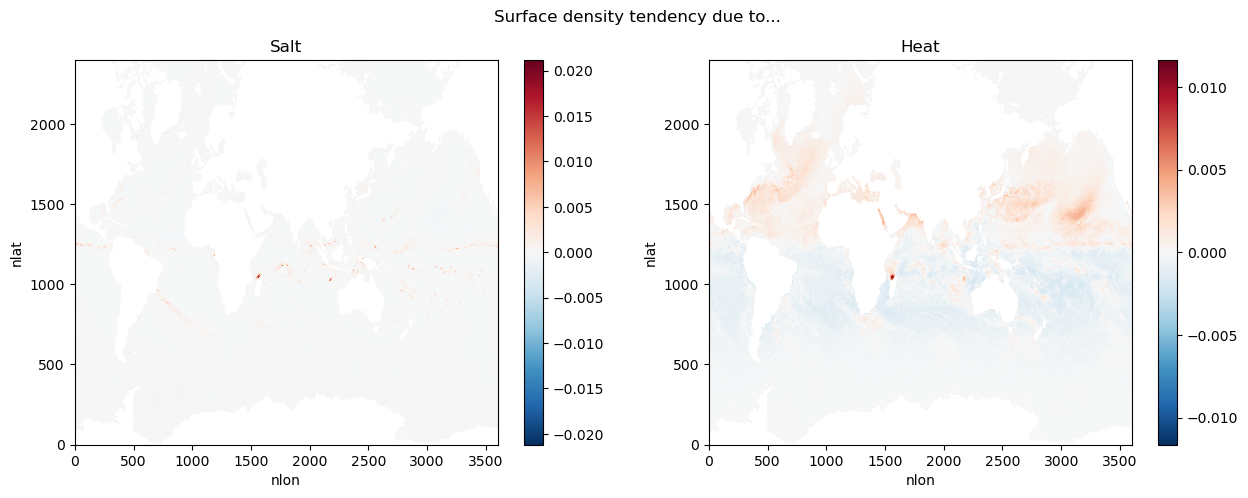

In [32]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))

(tend_surf_salt/1e6)[0].plot(ax=ax0)
ax0.set_title('Salt')

(tend_surf_heat/1e6)[0].plot(ax=ax1)
ax1.set_title('Heat')
plt.suptitle('Surface density tendency due to...');

In [33]:
surf_tend = xr.merge([tend_surf_salt.rename('surf_salt'), tend_surf_heat.rename('surf_heat')])

## Split salt/heat tendencies by basin

In [34]:
#assign each region index value to basin name

caspian_sea = -14
black_sea = -13
#unknown = -1
#unknown = 0
southern_ocean = 1
pacific_ocean = 2
indian_ocean = 3
persian_gulf = 4
red_sea = 5
atlantic_ocean = 6
med_sea = 7
lab_sea = 8
norwegian_sea = 9
arctic_ocean = 10
hudson_bay = 11
baltic_sea = 12

In [35]:
#combining atl, lab and norwegian sea masks together
nor_bool = ds.REGION_MASK.where(ds.REGION_MASK==9).notnull()
lab_bool = ds.REGION_MASK.where(ds.REGION_MASK==8).notnull()
atl_bool = ds.REGION_MASK.where(ds.REGION_MASK==6).notnull()

In [36]:
atl_mask = (nor_bool+lab_bool+atl_bool)

In [37]:
def basin_selection(ds, basin):
    tendency_in_basin = ds.where(ds.REGION_MASK==basin)
    return tendency_in_basin

In [38]:
all_tendencies = list(surf_tend)

In [39]:
#Atlantic Ocean - going to add 'NATL' prefix after adding natl_ocean+nor_sea+lab_sea respective vars
natl_ocean = xr.merge([surf_tend[var].where(atl_mask).isel(nlat=slice(1200, None)
                                                          ).rename('NATL_' + var) for var in all_tendencies])
satl_ocean = xr.merge([basin_selection(surf_tend[var], 
                                      atlantic_ocean).isel(nlat=slice(None, 1200)
                                                          ).rename('SATL_' + var) for var in all_tendencies])

#Pacific Ocean
npac_ocean = xr.merge([basin_selection(surf_tend[var], 
                                       pacific_ocean).isel(nlat=slice(1200, None)
                                                          ).rename('NPAC_' + var) for var in all_tendencies])
spac_ocean = xr.merge([basin_selection(surf_tend[var], 
                                       pacific_ocean).isel(nlat=slice(None, 1200)
                                                          ).rename('SPAC_' + var) for var in all_tendencies])

#Indian Ocean
ind_ocean = xr.merge([basin_selection(surf_tend[var], indian_ocean).rename('IND_' + var) for var in all_tendencies])

#Arctic Ocean
arc_ocean = xr.merge([basin_selection(surf_tend[var], arctic_ocean).rename('ARC_' + var) for var in all_tendencies])

#Southern Ocean
south_ocean = xr.merge([basin_selection(surf_tend[var], 
                                        southern_ocean).rename('South_' + var) for var in all_tendencies])

# Plot surf salt/heat tendencies by basin

## North Atlantic

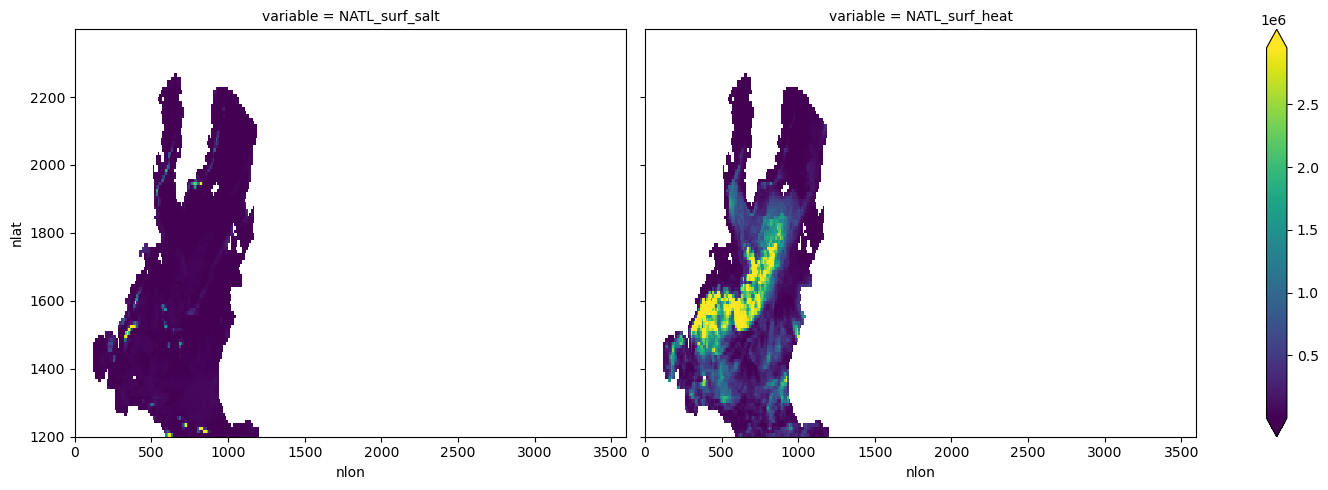

In [40]:
(natl_ocean.isel(time=0)**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', 
                                                                         robust=True, 
                                                                         figsize=(15, 5))

## South Atlantic

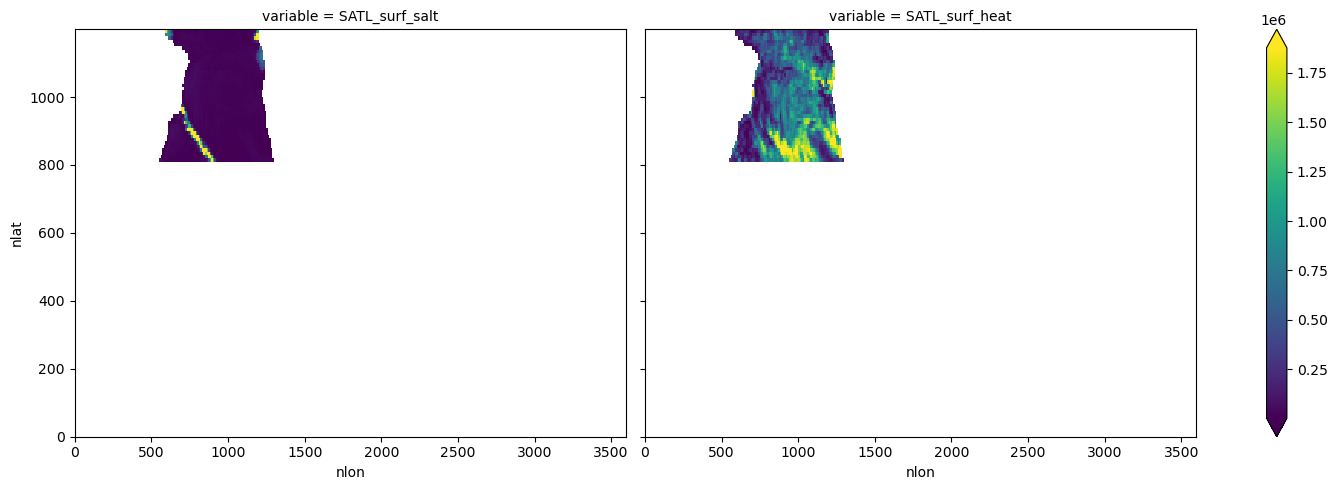

In [41]:
(satl_ocean.isel(time=0)**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', 
                                                                         robust=True, 
                                                                         figsize=(15, 5));

## North Pacific

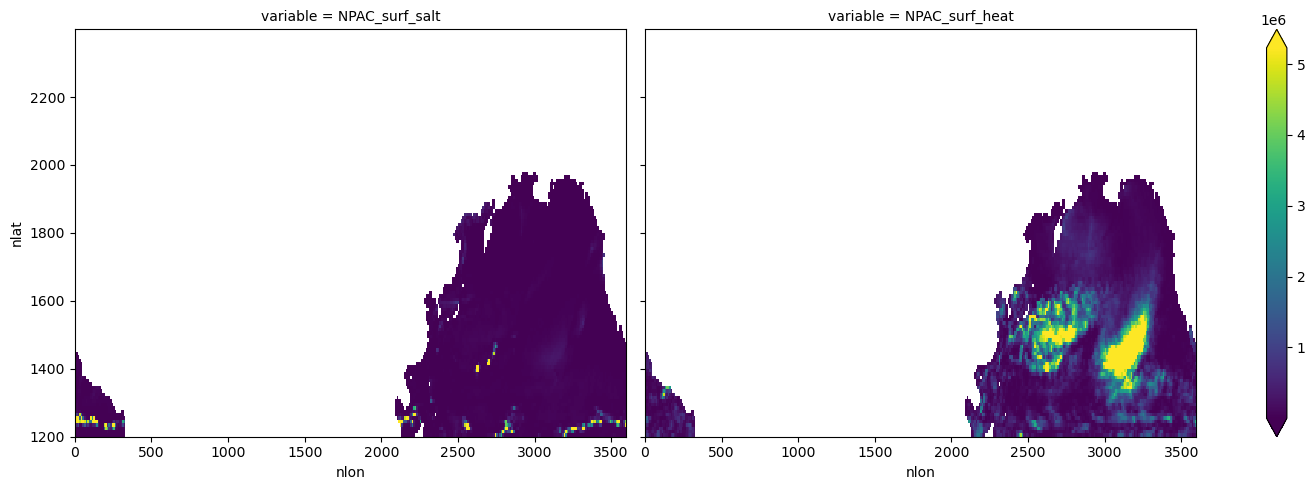

In [42]:
(npac_ocean.isel(time=0)**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', 
                                                                         robust=True, 
                                                                         figsize=(15, 5));

## South Pacific

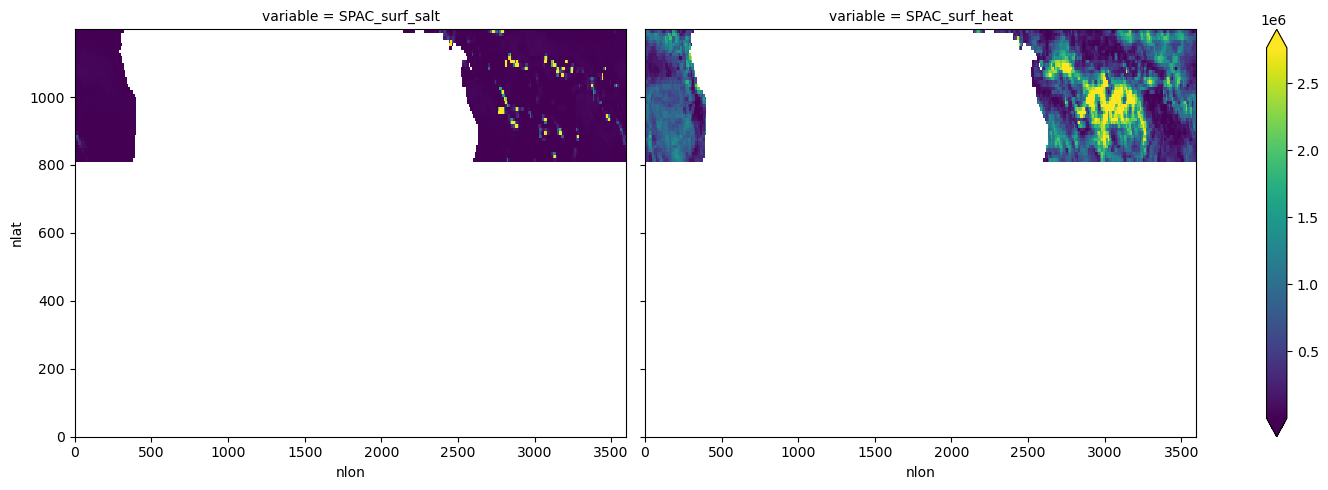

In [43]:
(spac_ocean.isel(time=0)**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', 
                                                                         col_wrap=2, robust=True, 
                                                                         figsize=(15, 5));

## Indian

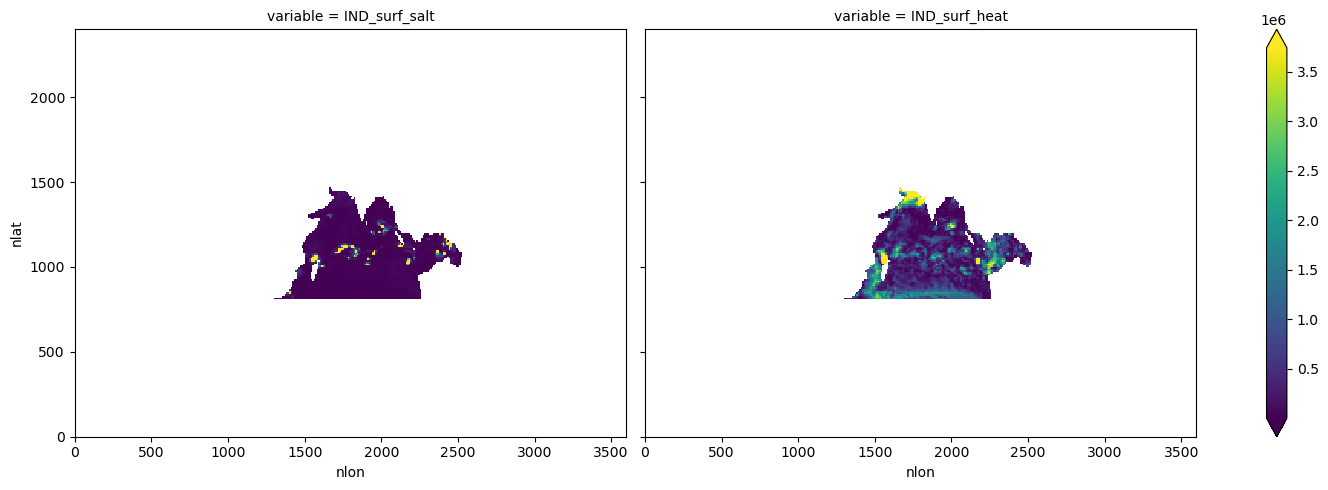

In [44]:
(ind_ocean.isel(time=0)**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', 
                                                                         robust=True, 
                                                                         figsize=(15, 5));

## Arctic

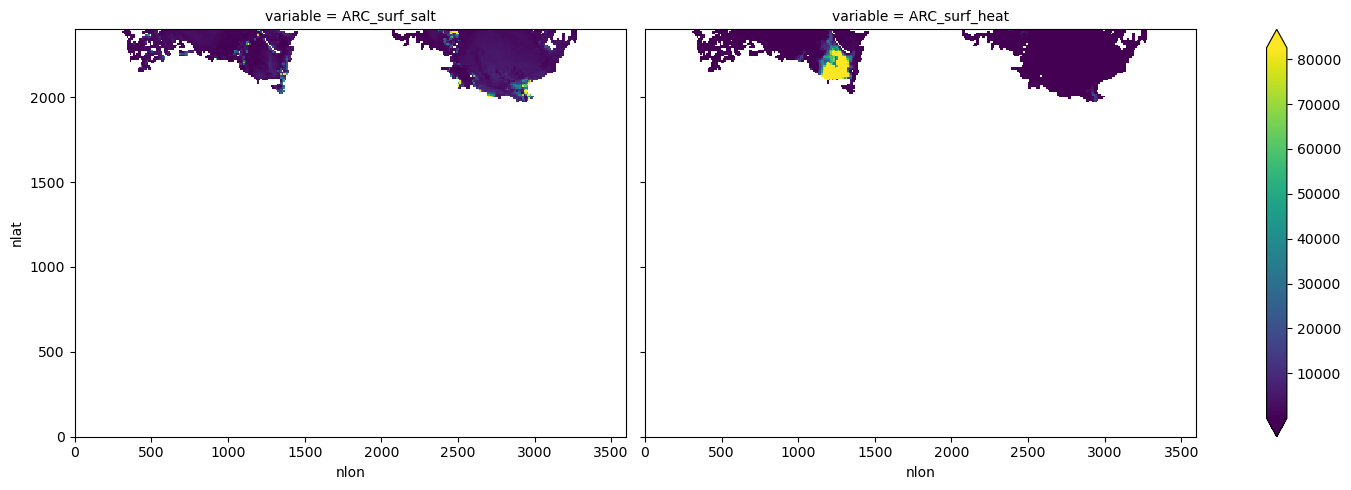

In [45]:
(arc_ocean.isel(time=0)**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', 
                                                                         col_wrap=2, robust=True, 
                                                                         figsize=(15, 5));

## Southern

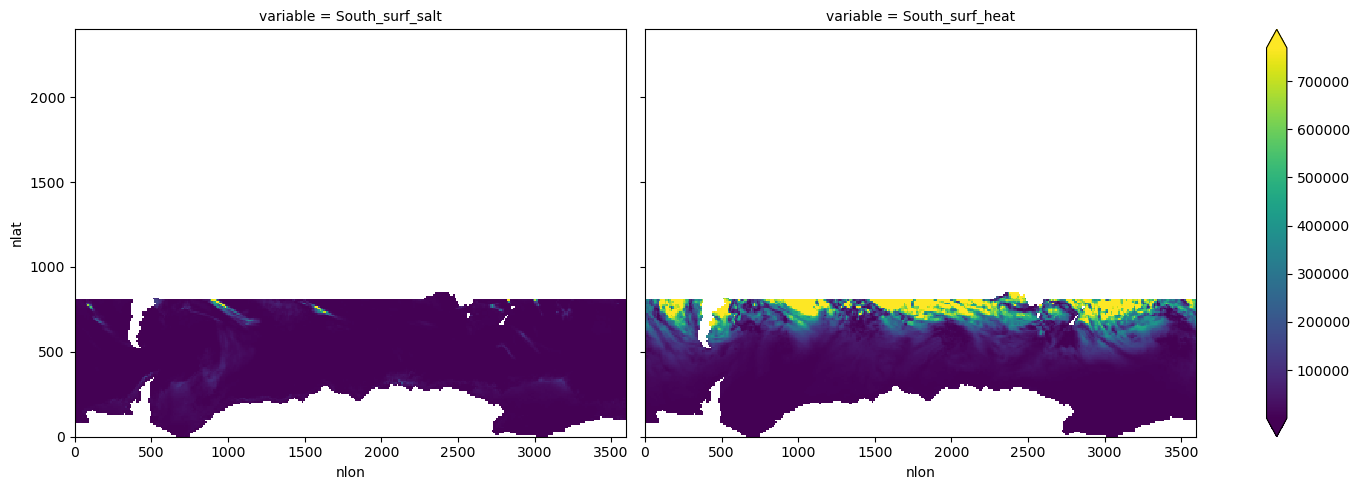

In [46]:
(south_ocean.isel(time=0)**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', 
                                                                         robust=True, 
                                                                         figsize=(15, 5));

## Compute histogram by basin

In [47]:
rho = fastjmd95.rho(ds.SSS, ds.SST, 0)
#rho = rho_unsliced.isel(time=slice(0,182))

In [48]:
delta_rho = 0.01
rho_bins = np.arange(1015, 1030, delta_rho)

In [49]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for surface tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=variable.fillna(0.), dim=['nlon', 'nlat'])
    return hist / delta_rho

In [50]:
def histogram_func_north_south(variable, slicing=None):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""

    if slicing=='north':
        hist = histogram(rho.isel(nlat=slice(1200, None)).rename('rho0'), bins=[rho_bins],
                         weights=variable.fillna(0.), 
                         dim=['nlon', 'nlat']) / delta_rho
    elif slicing=='south':
        hist = histogram(rho.isel(nlat=slice(None, 1200)).rename('rho0'), bins=[rho_bins],
                         weights=variable.fillna(0.), 
                         dim=['nlon', 'nlat']) / delta_rho
    return hist

In [51]:
natl_tendencies = list(natl_ocean)
satl_tendencies = list(satl_ocean)
npac_tendencies = list(npac_ocean)
spac_tendencies = list(spac_ocean)
ind_tendencies = list(ind_ocean)
arc_tendencies = list(arc_ocean)
south_tendencies = list(south_ocean)

In [52]:
natl_ocean

<xarray.Dataset>
Dimensions:             (nlat: 1200, nlon: 3600, time: 14965)
Coordinates: (12/54)
  * nlat                (nlat) int64 1200 1201 1202 1203 ... 2396 2397 2398 2399
  * nlon                (nlon) int64 0 1 2 3 4 5 ... 3595 3596 3597 3598 3599
  * time                (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:0...
    ANGLE               (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... -1.0 -1.0 -1.0
    ANGLET              (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... -1.0 -1.0 -1.0
    DXT                 (nlat, nlon) float64 1.111e+06 1.111e+06 ... -1.0 -1.0
    ...                  ...
    salt_to_ppt         float64 0.0
    sea_ice_salinity    float64 0.0
    sflux_factor        float64 0.0
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
    vonkar              float64 0.0
Data variables:
    NATL_surf_salt      (time, nlat, nlon) float64 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    NATL_surf_heat      (time, nlat, nlon) float64 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>

In [54]:
natl_histograms = xr.merge([histogram_func_north_south(natl_ocean[var], 'north').rename('OMEGA_' + var)
                      for var in natl_tendencies])
satl_histograms = xr.merge([histogram_func_north_south(satl_ocean[var], 'south').rename('OMEGA_' + var)
                      for var in satl_tendencies])

In [55]:
npac_histograms = xr.merge([histogram_func_north_south(npac_ocean[var], 'north').rename('OMEGA_' + var)
                      for var in npac_tendencies])
spac_histograms = xr.merge([histogram_func_north_south(spac_ocean[var], 'south').rename('OMEGA_' + var)
                      for var in spac_tendencies])

In [56]:
ind_histograms = xr.merge([histogram_func(ind_ocean[var]).rename('OMEGA_' + var)
                      for var in ind_tendencies])
arc_histograms = xr.merge([histogram_func(arc_ocean[var]).rename('OMEGA_' + var)
                      for var in arc_tendencies])
south_histograms = xr.merge([histogram_func(south_ocean[var]).rename('OMEGA_' + var)
                      for var in south_tendencies])

Task exception was never retrieved
future: <Task finished name='Task-4498' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit


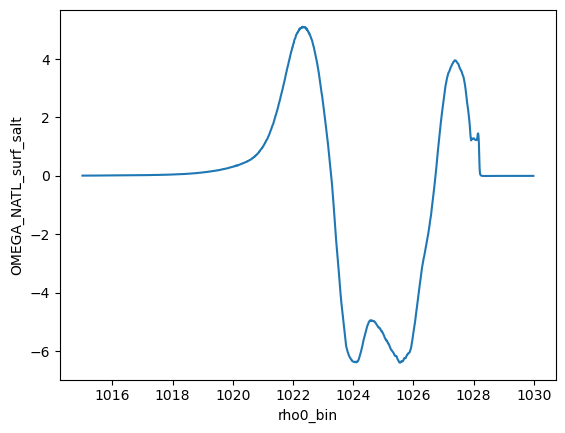

In [61]:
#visual check to see if magnitude is reasonable
(natl_histograms.OMEGA_NATL_surf_salt/1e6).mean('time').plot()

# 2) Save histograms <a class='anchor' id='second-bullet'> </a>

In [62]:
#saving north atlantic basin histograms
gcsmap_hist_natl = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/surf_natl_histograms.zarr')
natl_histograms.to_zarr(gcsmap_hist_natl, mode='w')

In [63]:
#saving south atlantic basin histograms
gcsmap_hist_satl = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/surf_satl_histograms.zarr')
satl_histograms.to_zarr(gcsmap_hist_satl, mode='w')

In [64]:
#saving north pacific basin histograms
gcsmap_hist_npac = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/surf_npac_histograms.zarr')
npac_histograms.to_zarr(gcsmap_hist_npac, mode='w')

In [65]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.ce23e04f56314570bb6472b8e3987ce7/status,


In [66]:
#saving south pacific basin histograms
gcsmap_hist_spac = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/surf_spac_histograms.zarr')
spac_histograms.to_zarr(gcsmap_hist_spac, mode='w')

In [67]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.ce23e04f56314570bb6472b8e3987ce7/status,


In [72]:
#saving indian basin histograms
gcsmap_hist_ind = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/surf_ind_histograms.zarr')
ind_histograms.to_zarr(gcsmap_hist_ind, mode='w')

Task exception was never retrieved
future: <Task finished name='Task-4608' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit


In [ ]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.67bbfdc22f694f79848b95e388977d54/status,


In [ ]:
#saving arctic basin histograms
gcsmap_hist_arc = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/surf_arc_histograms.zarr')
arc_histograms.to_zarr(gcsmap_hist_arc, mode='w')

In [ ]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.67bbfdc22f694f79848b95e388977d54/status,


In [ ]:
#saving southern basin histograms
gcsmap_hist_south = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/surf_south_histograms.zarr')
south_histograms.to_zarr(gcsmap_hist_south, mode='w')

In [68]:
cluster.close()
client.close()